<a href="https://colab.research.google.com/github/stevengregori92/RNN-Intro/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'jcopdl<2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Import Dataset

In [4]:
!gdown https://drive.google.com/uc?id=1i-VQ3pObgo53p2xtQdE805aObpVQXnTX

Downloading...
From: https://drive.google.com/uc?id=1i-VQ3pObgo53p2xtQdE805aObpVQXnTX
To: /content/energy.zip
100% 35.6k/35.6k [00:00<00:00, 30.3MB/s]


In [5]:
!gdown https://drive.google.com/uc?id=18y76hccJ6C7CD0uMJ2KjSFGJhYx168sR

Downloading...
From: https://drive.google.com/uc?id=18y76hccJ6C7CD0uMJ2KjSFGJhYx168sR
To: /content/utils.py
100% 1.71k/1.71k [00:00<00:00, 7.83MB/s]


In [6]:
!unzip /content/energy.zip

Archive:  /content/energy.zip
replace KwhConsumptionBlower78_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
df = pd.read_csv('KwhConsumptionBlower78_3.csv', parse_dates=['TxnDate'], index_col = 'TxnDate')
df

,Unnamed: 0,TxnTime,Consumption
TxnDate,,,
2022-02-01,0,14:41:48,1.016
2022-02-01,1,17:28:44,0.928
2022-02-01,2,19:51:07,0.988
2022-02-01,3,07:26:39,1.126
2022-02-01,4,05:20:47,0.886
...,...,...,...
2022-02-28,1743,22:01:52,1.020
2022-02-28,1744,08:54:15,0.948
2022-02-28,1745,06:26:48,0.912


<Axes: xlabel='TxnDate'>

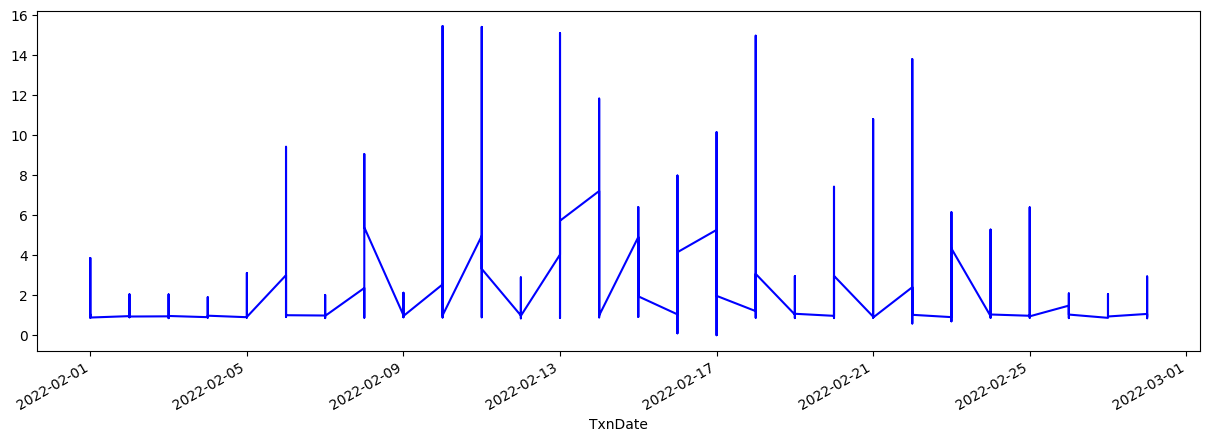

In [8]:
df.Consumption.plot(figsize=(15,5), color = 'b')

In [9]:
df['TxnTime'] = pd.to_datetime(df['TxnTime'])
df['TxnTime'] = df['TxnTime'].dt.hour

In [10]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1748 entries, 2022-02-01 to 2022-02-28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TxnTime      1748 non-null   int64  
 1   Consumption  1748 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 41.0 KB


In [12]:
df.iloc[0:2]

,TxnTime,Consumption
TxnDate,,
2022-02-01,14,1.016
2022-02-01,17,0.928


#Dataset Splitting

In [13]:
ts_train, ts_test = train_test_split(df, test_size=.2, shuffle = False)
ts_train.shape, ts_test.shape

((1398, 2), (350, 2))

#Dataset & Dataloader

In [14]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [15]:
seq_len = 5
bs = 64

train_set = TimeSeriesDataset(ts_train, 'Consumption', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Consumption', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (279, 5, 2)
Note: last 2 data excluded

(N, S, F): (69, 5, 2)
Note: last 4 data excluded



#Arsitektur & Config

In [16]:
from jcopdl.layers import linear_block

In [17]:
class LSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first = True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.rnn(x, hidden)
    x = self.fc(x)
    return x, hidden

In [18]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'seq_len': train_set.n_seq
})

#Training -> MCOC

In [19]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir='model/lstm')

#Training

In [20]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode=='train':
    model.train()
  elif mode =='test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode =='train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost+=loss.item() * feature.shape[0]

  cost = cost/len(dataset)
  return cost

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 9.0577 | Test_cost  = 3.3221 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 8.1836 | Test_cost  = 2.7841 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 7.1969 | Test_cost  = 2.3305 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 6.1651 | Test_cost  = 2.3852 | 
==> EarlyStop patience =  1 | Best test_cost: 2.3305


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 5.6043 | Test_cost  = 3.0588 | 
==> EarlyStop patience =  2 | Best test_cost: 2.3305


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 5.6743 | Test_cost  = 3.2912 | 
==> EarlyStop patience =  3 | Best test_cost: 2.3305


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 5.6487 | Test_cost  = 3.0152 | 
==> EarlyStop patience =  4 | Best test_cost: 2.3305


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 5.4909 | Test_cost  = 2.6754 | 
==> EarlyStop patience =  5 | Best test_cost: 2.3305
==> Execute Early Stopping at epoch: 8 | Best test_cost: 2.3305
==> Best model is saved at model/lstm


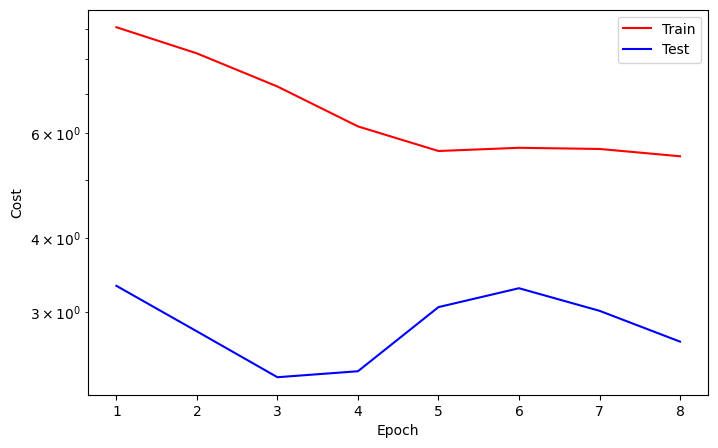

In [21]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  callback.log(train_cost, test_cost)

  callback.save_checkpoint()

  callback.cost_runtime_plotting()

  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

#Forecast

In [22]:
from utils import data4pred, pred4pred

In [23]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Consumption', 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, 'Consumption', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (1397, 1, 2)
Note: last 0 data excluded

(N, S, F): (349, 1, 2)
Note: last 0 data excluded



#Pred From Data

Text(0.5, 1.0, 'Test')

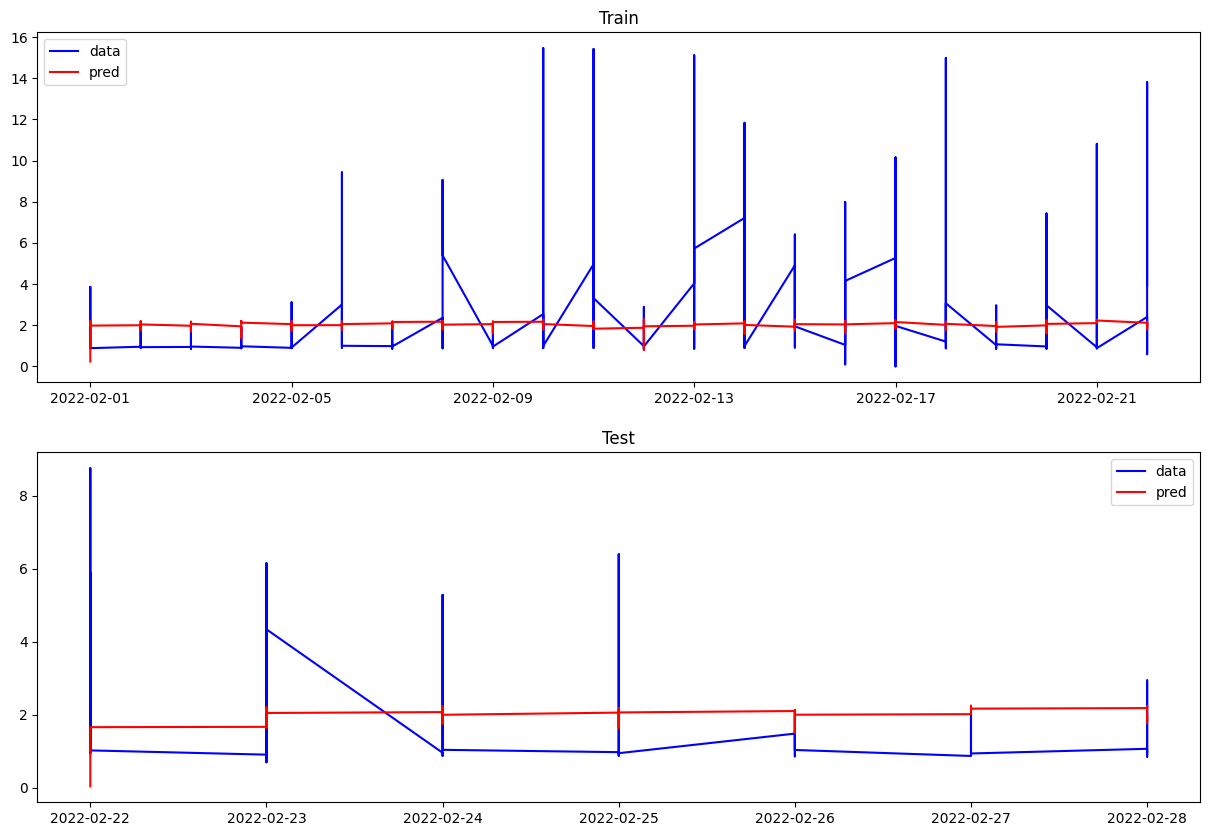

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")
